# Processing API request

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import time
import datetime
import numpy as np

import matplotlib.pyplot as plt 

from eolearn.io import SentinelHubProcessingInput, SentinelHubWCSInput
from eolearn.core import FeatureType, OverwritePermission
from sentinelhub import CRS, BBox, DataSource

import logging, sys
logging.basicConfig(stream=sys.stdout)
logging.getLogger("eolearn.io.processing_api").setLevel(logging.DEBUG)
logging.getLogger("sentinelhub.sentinelhub_client").setLevel(logging.DEBUG)
logging.getLogger("sentinelhub.sentinelhub_rate_limit").setLevel(logging.DEBUG)

In [2]:
size_x = 100
size_y = 100
bbox = BBox(bbox=[268892, 4624365, 268892+size_x*10, 4624365+size_y*10], crs=CRS.UTM_33N) 
#time_interval = ('2017-12-15', '2017-12-30')
time_interval = ('2017-12-15', '2018-1-30')
#time_interval = ('2017-12-15', '2018-12-15')
maxcc = 0.8
time_difference = 60
data_source = DataSource.SENTINEL2_L1C
layer = {DataSource.SENTINEL2_L1C: 'BANDS-S2-L1C', DataSource.SENTINEL2_L2A: 'BANDS-S2-L2A'}[data_source]

In [3]:
task = SentinelHubProcessingInput(
    'test_feature',
    size_x=size_x,
    size_y=size_y,
    time_range=time_interval,
    bbox=bbox,
    maxcc=maxcc,
    time_difference=time_difference,
    data_source=data_source,
    max_threads=3
)

In [4]:
%%time
eopatch_proc = task.execute()
proc_images = eopatch_proc[(FeatureType.DATA, 'test_feature')]
is_data = eopatch_proc[(FeatureType.MASK,'IS_DATA')]

DEBUG:eolearn.io.processing_api:Starting 10 processing requests with 3 threads.
DEBUG:sentinelhub.sentinelhub_client:[140410231961344] START DOWNLOAD
DEBUG:sentinelhub.sentinelhub_client:[140410240354048] START DOWNLOAD
DEBUG:sentinelhub.sentinelhub_client:[140410282301184] START DOWNLOAD
DEBUG:sentinelhub.sentinelhub_client:[140410231961344] UPDATE: req_limit(9999.0), req_retry(0), token_limit(9999.83469644576), token_retry(0)
DEBUG:sentinelhub.sentinelhub_client:[140410231961344] DONE
DEBUG:sentinelhub.sentinelhub_client:[140410231961344] START DOWNLOAD
DEBUG:sentinelhub.sentinelhub_client:[140410240354048] UPDATE: req_limit(9999.0), req_retry(0), token_limit(9999.83469644576), token_retry(0)
DEBUG:sentinelhub.sentinelhub_client:[140410240354048] DONE
DEBUG:sentinelhub.sentinelhub_client:[140410240354048] START DOWNLOAD
DEBUG:sentinelhub.sentinelhub_client:[140410231961344] UPDATE: req_limit(9999.0), req_retry(0), token_limit(9999.83469644576), token_retry(0)
DEBUG:sentinelhub.sentin

# Request the same image with the SentinelHubWCSInput for comparison

In [5]:
input_task = SentinelHubWCSInput(
    layer=layer,
    resx='10m',
    resy='10m',
    maxcc=maxcc,
    data_source=data_source
)

In [6]:
%%time
eopatch_wcs = input_task.execute(
    bbox=bbox,
    time_interval=time_interval
)

CPU times: user 418 ms, sys: 41.4 ms, total: 459 ms
Wall time: 1.59 s


In [7]:
wcs_images = eopatch_wcs.data[layer]

# Result comparison

In [8]:
print('WCS shape..........:', wcs_images.shape)
print('PROCESSING shape...:', proc_images.shape)

WCS shape..........: (10, 100, 100, 13)
PROCESSING shape...: (10, 100, 100, 13)


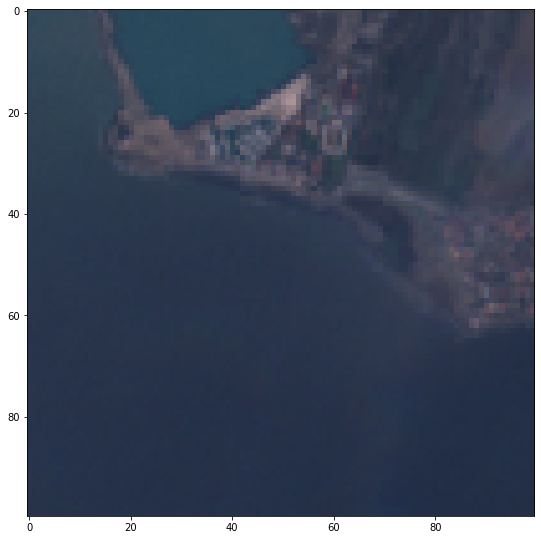

In [9]:
image_index = 0
plt.figure(figsize=(20,20))
plt.subplot2grid((1, 2), (0, 0)).imshow(proc_images[image_index][..., [3,2,1]] * 2.5, vmin=0, vmax=1);
#plt.subplot2grid((1, 2), (0, 1)).imshow(wcs_images[image_index][..., [3,2,1]] * 2.5, vmin=0, vmax=1);

In [10]:
diffs = np.abs(proc_images - wcs_images)
whr = np.where(diffs != 0)
print('Arrays equal:', np.array_equal(proc_images, wcs_images))
print('Differing values percentage: {}%'.format((proc_images[whr].size / proc_images.size) * 100))
print('Maximum difference:', np.max(diffs))
print('Mean difference:', np.mean(diffs))

Arrays equal: False
Differing values percentage: 16.121384615384613%
Maximum difference: 1.1920929e-07
Mean difference: 2.500626e-09


In [11]:
proc_images[0,3,5,2], wcs_images[0,3,5,2]

(0.118999995, 0.119)

# 16bit vs 32 bit storage

In [39]:
eopatch_proc.save('processing_patch', compress_level=9, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [40]:
import os
import math

def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)

    return convert_size(total_size)

In [41]:
print('cache:', get_size('cache_dir'))
print('32bit:', get_size('processing_patch'))

cache: 0B
32bit: 334.86 KB
